# Python code for APPM 4720/5720, HW 6, Logistic Regression

In [56]:
import cvxpy as cp
import numpy as np

In [58]:
def l_w(w, y, X):
    return np.sum(np.log(1 + np.exp(-y * (X @ w))))

def sigma(a):
    return 1/(1 + np.exp(-a))

def make_mu(y, w, X):
    return sigma(y * (w @ X.T))

def grad_l(X, y, w):
    mu = make_mu(y, w, X)
    return -X.T @ (y * (1 - mu)).flatten()

In [59]:
# There's not much point in running this, since it's just objectively worse than the one above,
# but it was easier for me to reason about and helped check that the grad_l above is implemented correctly

def slow_grad_l(X, y, w):
    i = 0
    running = sigma(-y[i] * (w @ X[i, ])) * y[i] * X[i, ]
    for i in range(1, y.shape[0]):
        running += sigma(-y[i] * (w @ X[i, ])) * y[i] * X[i, ]
    
    return -running

In [60]:
def finite_diff(f, grad_f, x_0, h=1e-6):
    g = []
    
    for i in range(len(x_0)):
        h_i = np.zeros(len(x_0))
        h_i[i] = h
        
        g.append((f(x_0 + h_i) - f(x_0)) / h)
    
    g = np.array(g)
    
    return np.mean(g - grad_f(x_0))

def finite_diff_centered(f, grad_f, x_0, h=1e-6):
    g = []
    
    for i in range(len(x_0)):
        h_i = np.zeros(len(x_0))
        h_i[i] = h
        
        g.append((f(x_0 + h_i) - f(x_0 - h_i)) / (2*h))
    
    g = np.array(g)
    
    return np.mean(g - grad_f(x_0))

def taylor_remainder_test(f, grad_f, x_0, delta=1, h=1e-6):
    x_1 = x_0 + delta
    first_order = np.abs(f(x_0) - f(x_0 + h*x_1)).mean()
    second_order = np.abs(f(x_0) + np.dot(grad_f(x_0), h*x_1) - f(x_0 + h*x_1)).mean()
    
    return first_order, second_order

Just running a few toy examples to make sure it works.

In [61]:
finite_diff(lambda x: 0.5*np.linalg.norm(x)**2, lambda x: x, x_0 = np.array([1, 2, 3, 4, 5, 700]))

-4.526227712631226e-06

In [62]:
finite_diff_centered(lambda x: 0.5*np.linalg.norm(x)**2, lambda x: x, x_0 = np.array([1, 2, 3, 4, 5, 700]))

-6.9515469173590345e-06

In [63]:
taylor_remainder_test(lambda x: 0.5*np.linalg.norm(x)**2, lambda x: x, x_0 = np.array([1, 2, 3, 4, 5, 700]))

(0.4907702458149288, 2.4581095203757286e-07)

In [64]:
def gradient_check(f, grad_f, x_0):
    for i in range(12):
        h = 10**(-i)
        
        result = finite_diff(f, grad_f, x_0, h = h)
        result2 = finite_diff_centered(f, grad_f, x_0, h=h)
        
        print(h, result, result2)

In [65]:
print('h, fd, fdc')
gradient_check(lambda x: 0.5*np.linalg.norm(x)**2, lambda x: x, x_0 = np.array([2, 3, 4, 5, 6, 7, 8]))

h, fd, fdc
1 0.5000000000000101 -2.0301221021717147e-15
0.1 0.05000000000017784 0.0
0.01 0.005000000001505863 2.2331343123888862e-13
0.001 0.0005000000124612468 -1.5022903556070689e-12
0.0001 5.000016504449637e-05 3.573014899822218e-12
1e-05 5.000559732325018e-06 -1.385360715033812e-10
1e-06 5.111477158996942e-07 -4.4305384757795506e-10
1e-07 2.3099086579999755e-07 7.677434561108904e-09
1e-08 1.124244590755552e-06 -1.9533477565606257e-07
1e-09 1.2086903942482813e-05 -4.154072875017789e-06
1e-10 8.923154382500798e-05 -3.257578230529491e-05
1e-11 0.0016118231204537941 0.00029224375404217947


## Gradient descent and line search

In [66]:
def armijo_linesearch(f, grad_f, x_k, t=0.1):
    p_k = - grad_f(x_k) # for gradient descent, p_k comes from grad_f
    ro = 0.9
    c = 1e-4
    
    while (f(x_k + t*p_k) > f(x_k) + c*t*np.dot(grad_f(x_k), p_k)).all():
        t = ro*t
    
    return t

def gradient_descent(f, grad_f, x_0=0, threshold=1e-4, max_iter=1e10, calc_progress=False):
    x = x_0
    grad = grad_f(x)
    t = 0.1
    i = 0
    
    progress = []
    progress_test = []
    
    while np.linalg.norm(grad) > threshold:
        t = armijo_linesearch(f, grad_f, x, t*2)
        
        x = x - t*grad
        grad = grad_f(x)
        i += 1
        
        # So this method closes over these variables defined BELOW this block to save the progress of the spam run...
        # Super hacky!
        if i % 20 == 0 and calc_progress:
            score = ((np.floor(sigma(a=Xtrain @ x)*2)*2 - 1) == Ytrain).sum() / Xtrain.shape[0]
            testscore = ((np.floor(sigma(a=Xtest @ x)*2)*2 - 1) == Ytest).sum() / Xtest.shape[0]

            progress.append(score)
            progress_test.append(testscore)
        
        if i > max_iter:
            print("Max iterations reached.")
            return x, progress, progress_test
    
    print("Total iterations:", i)
    return x, progress, progress_test

In [67]:
# toy example of this running

gradient_descent(lambda x: (x + 2)**2, lambda x: 2*x + 4, x_0 = np.array([5, 6]))

Total iterations: 92


(array([-1.99996908, -1.99996467]), [], [])

## Problem 3 (Analytical test that the gradient descent works)

In [68]:
y = np.random.choice([-1, 1], size=100)

In [69]:
A = np.array([[1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0 ,0 , 1],
            [1, 1, 1, 1]])

b = np.array([5, 6, 7, 8, 9])

ground_truth = np.linalg.inv(A.T @ A) @ A.T @ b
ground_truth

array([1.6, 2.6, 3.6, 4.6])

In [70]:
f = lambda x: 0.5 * np.linalg.norm(A@x - b)**2
grad_f = lambda x: 2*A.T@A@x -2*A.T@b
x_0 = np.array([1, 2, 3, 4])
               
gradient_descent(f, grad_f, x_0 = x_0, max_iter=1000, threshold=1e-100)

Max iterations reached.


(array([1.6, 2.6, 3.6, 4.6]), [], [])

In [71]:
errs = []
for i in np.arange(0, 200, 20):
    errs.append((gradient_descent(f, grad_f, x_0 = x_0, max_iter=i, threshold=1e-100)[0] - ground_truth)[0])

Max iterations reached.
Max iterations reached.
Max iterations reached.
Max iterations reached.
Max iterations reached.
Max iterations reached.
Max iterations reached.
Max iterations reached.
Max iterations reached.
Max iterations reached.


/home/sam/math/convex/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


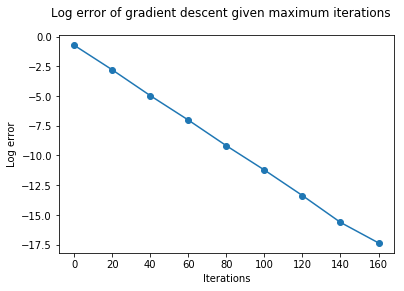

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel('Iterations')
plt.ylabel('Log error')
plt.suptitle('Log error of gradient descent given maximum iterations')
plt.plot(20 * np.arange(10), np.log(errs), marker='o')

# Loading and classifying the spam data

In [73]:
# logistic regression
import scipy.io
import pandas as pd

spam_data = scipy.io.loadmat('../data/spamData.mat')

In [74]:
Xtrain = np.log(spam_data['Xtrain'] + 0.1)
Ytrain = spam_data['ytrain'].flatten()
Xtest = np.log(spam_data['Xtest'] + 0.1)
Ytest = spam_data['ytest'].flatten()

Ytrain.dtype = 'int8'
Ytest.dtype = 'int8'

Ytrain = Ytrain*2 - 1
Ytest = Ytest*2 - 1

In [75]:
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((3065, 57), (3065,), (1536, 57), (1536,))

In [76]:
# Bake ("curry") the other variables in, since the way I wrote the solver it requires the function to only take one
# variable

l_w_spam_train = lambda w: l_w(X=Xtrain, y=Ytrain, w=w)
grad_l_spam_train = lambda w: grad_l(X=Xtrain, y=Ytrain, w=w)

In [77]:
taylor_remainder_test(l_w_spam_train, grad_l_spam_train, x_0 = np.zeros(57))

(0.03839755555509328, 3.7005393096478656e-06)

In [78]:
found_w, progress, progress_test = gradient_descent(l_w_spam_train, grad_l_spam_train, x_0=np.zeros(57), max_iter=1000, calc_progress=True)

/home/sam/math/convex/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Max iterations reached.


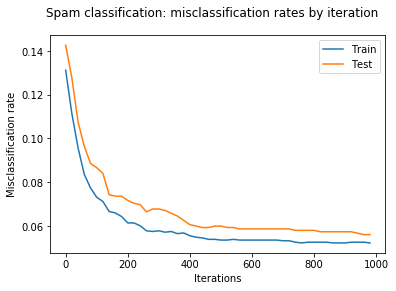

In [79]:
plt.plot(np.arange(1000/20)*20, 1 - np.array(progress), label='Train')
plt.plot(np.arange(1000/20)*20, 1 - np.array(progress_test), label='Test')

plt.xlabel('Iterations')
plt.ylabel('Misclassification rate')

plt.suptitle('Spam classification: misclassification rates by iteration')
plt.legend()